In [ ]:
using DataStructures
using Dates
import Random: randstring

# Function to recursively remove line number nodes
function _clean_expr!(ex)
    if ex isa Expr
        # replace!(arg -> typeof(arg) <: LineNumberNode ? :() : arg, ex.args)
        Base.remove_linenums!(ex)
        foreach(_clean_expr!, ex.args)
    end
    ex
end

function _print_expression(expr)
    println(_clean_expr!(deepcopy(expr)))
end

"""
A node in a stream computation graph that represents a computation step.

Types of nodes:
- **Source only**: The node has no incoming edges, emits data.
- **Sink only**: The node has no outgoing edges, consumes/stores data.
- **Operation**: The node has both incoming and outgoing edges, and performs a computation step.
    - **Stateful**: The node has an internal state that is updated during computation.
    - **Stateless**: The node has no internal state, and the output is a function of the input only.
"""
mutable struct StreamNode{TGraph}
    graph::TGraph
    index::Int
    is_source::Bool
    func::Function
    inputs::Vector{StreamNode}
    output_type::Type
    init_value::Any
    label::String
    field_name::Symbol
    function StreamNode(graph::TGraph, index, is_source, func, output_type, init_value, label) where {TGraph}
        field_name = Symbol("$(label)")
        new{TGraph}(graph, index, is_source, func, StreamNode[], output_type, init_value, label, field_name)
    end
end

@inline is_source(node::StreamNode) = node.is_source
@inline is_sink(node::StreamNode) = node.output_type == Nothing
# @inline is_join(node::StreamNode) = length(node.inputs) > 1
# @inline is_branch(node::StreamNode{TGraph}) where {TGraph} = length(node.graph.reverse_deps[node.index]) > 1

"""
A directed acyclic graph (DAG) that represents a stream computation graph.
"""
mutable struct StreamGraph
    nodes::Vector{StreamNode{StreamGraph}}
    source_nodes::Vector{Int}
    deps::Vector{Vector{Int}}
    reverse_deps::Vector{Vector{Int}}
    topo_order::Vector{Int}
    function StreamGraph()
        new(
            StreamNode{StreamGraph}[],
            Int[],
            Vector{Int}[],
            Vector{Int}[],
            Int[]
        )
    end
end

"""
Sort the nodes in the graph in topological order using a depth-first search (DFS).
"""
function topological_sort!(graph::StreamGraph)
    visited = falses(length(graph.nodes))
    temp_stack = Int[]

    for node_index in 1:length(graph.nodes)
        if !visited[node_index]
            push!(temp_stack, node_index)

            while !isempty(temp_stack)
                current_node = temp_stack[end]

                if !visited[current_node]
                    visited[current_node] = true
                    push!(graph.topo_order, current_node)
                end

                all_visited = true

                for dependent_index in graph.deps[current_node]
                    if !visited[dependent_index]
                        push!(temp_stack, dependent_index)
                        all_visited = false
                    end
                end

                if all_visited
                    pop!(temp_stack)
                end
            end
        end
    end

    if length(graph.topo_order) != length(graph.nodes)
        error("Graph has a cycle")
    end

    nothing
end

"""
Check if the graph is weakly connected, i.e., there is a path between every pair of nodes.
If not, the graph is not fully connected and some nodes will never be reached.

Also check that there is at least one source node in the graph.
"""
function verify_graph(graph::StreamGraph)
    isempty(graph.nodes) && error("Empty graph.")
    isempty(graph.source_nodes) && error("No source nodes in the graph.")

    visited = falses(length(graph.nodes))
    stack = copy(graph.source_nodes)

    # Mark all source nodes as visited
    for source in stack
        visited[source] = true
    end

    # Perform DFS from all source nodes
    while !isempty(stack)
        node_index = pop!(stack)

        for ix in graph.reverse_deps[node_index]
            if !visited[ix]
                visited[ix] = true
                push!(stack, ix)
            end
        end
    end

    if !all(visited)
        msg = "Following nodes are not reachable from the source nodes, i.e. computation graph is not weakly connected: "
        for ix in findall(.!visited)
            msg *= "\n[$ix] $(graph.nodes[ix].label)"
        end
        error(msg)
    end
end

function _make_node_label(index::Int, func::Function, label::String)
    if isempty(label)
        label = "node #$index"
        # buffer = IOBuffer()
        # Base.show_unquoted(buffer, func)
        # label = String(take!(buffer))
    end
    label
end

function _make_node!(graph::StreamGraph, is_source::Bool, func::Function, output_type::Type, init_value::Any, label::String)
    # Array index of node in graph
    index = length(graph.nodes) + 1

    # Generate label for node
    label = _make_node_label(index, func, label)

    # Verify label is unique
    for node in graph.nodes
        node.label == label && error("Node with label '$label' already exists")
    end

    # Create node and add to graph
    node = StreamNode(graph, index, is_source, func, output_type, init_value, label)
    push!(graph.nodes, node)
    push!(graph.deps, Int[]) # The nodes that this node depends on
    push!(graph.reverse_deps, Int[]) # The nodes that depend on this node

    # Keep track of source nodes
    is_source && push!(graph.source_nodes, index)

    node
end

function op!(::Type{TOutput}, graph::StreamGraph, func::Function; init=nothing, label::String="") where {TOutput}
    _make_node!(graph, false, func, TOutput, init, label)
end

function source!(::Type{TOutput}, graph::StreamGraph; init=nothing, label::String="") where {TOutput}
    _make_node!(graph, true, identity, TOutput, init, label)
end

function sink!(graph::StreamGraph, func::Function; label::String="")
    _make_node!(graph, false, func, Nothing, nothing, label)
end

function bind!(inputs...; to::StreamNode{TGraph}) where {TGraph}
    is_source(to) && error("Cannot bind inputs to a source node")
    for input in inputs
        is_sink(input) && error("Cannot bind a sink node as input")
    end
    node = to
    graph = node.graph
    node.inputs = collect(inputs)
    input_indices = [input.index for input in node.inputs]
    graph.deps[node.index] = input_indices
    for input_index in input_indices
        push!(graph.reverse_deps[input_index], node.index)
    end
end

# syntactic sugar for binding inputs (bind!)
function Base.:|>(inputs, node::StreamNode{G}) where {G}
    for (i, input) in enumerate(inputs)
        input isa StreamNode || error("Input #$i is not a StreamNode")
    end
    bind!(inputs...; to=node)
    node
end

function Base.:|>(input::StreamNode{G}, node::StreamNode{G}) where {G}
    bind!(input; to=node)
    node
end

# ------------------------------

"""
Compile the states struct for the given graph to store intermediate results
of computation steps.
"""
function compile_states(::Type{TTime}, graph::StreamGraph) where {TTime}
    # Generate a unique name for the struct
    struct_name = Symbol("GraphStates_" * randstring(8))

    field_defs = []
    ctor_args = []

    # push!(field_defs, Expr(:(::), :__times, Vector{TTime}))
    # push!(ctor_args, :(fill(zero(TTime), $(length(graph.nodes)))))

    for (i, node) in enumerate(graph.nodes)
        # state value field
        field_type = :($(Union{node.output_type,typeof(node.init_value)}))
        push!(field_defs, Expr(:(::), node.field_name, field_type))
        push!(ctor_args, node.init_value)

        # state time field
        push!(field_defs, Expr(:(::), Symbol("$(node.field_name)__time"), TTime))
        push!(ctor_args, :(zero($TTime)))
    end

    struct_def = Expr(:struct, true, struct_name, Expr(:block, field_defs...))
    Core.eval(@__MODULE__, struct_def)

    ctor_def = :($struct_name() = $struct_name($(ctor_args...)))
    Core.eval(@__MODULE__, ctor_def)

    # println("Generated struct definition:")
    # println(struct_def)
    # println("Generated constructor:")
    # println(ctor_def)

    # Dict(zip(fieldnames(typeof(states)), fieldtypes(typeof(states))))

    getfield(@__MODULE__, struct_name)
end

# ------------------------------

struct ExecutionEvent{TTime,TFunc}
    timestamp::TTime
    source_index::Int
    func::TFunc
    ExecutionEvent(timestamp::TTime, source_index::Int, func::TFunc) where {TTime,TFunc} = new{TTime,TFunc}(timestamp, source_index, func)
end

@inline Base.isless(a::ExecutionEvent, b::ExecutionEvent) = a.timestamp < b.timestamp

# ------------------------------

abstract type StreamGraphExecutor end

"""
An executor that runs a stream computation graph in historic mode.
Historic means that the executor processes timestamped events that occurred in the past
at full speed, i.e., the current time of the executor is updated to the timestamp of the event.
"""
mutable struct HistoricExecutor{TStates,TTime} <: StreamGraphExecutor
    graph::StreamGraph
    states::TStates
    current_time::TTime
    event_queue::BinaryMinHeap{ExecutionEvent{TTime}}
    source_funcs::Vector{Function}
    function HistoricExecutor{TTime}(graph::StreamGraph, states::TStates) where {TStates,TTime}
        new{TStates,TTime}(graph, states, zero(TTime), BinaryMinHeap{ExecutionEvent{TTime}}(), Vector{Function}())
    end
end

@inline function time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.current_time
end

@inline function time!(executor::HistoricExecutor{TStates,TTime}, new_time::TTime) where {TStates,TTime}
    executor.current_time = new_time
    nothing
end

function compile_graph!(::Type{TTime}, g::StreamGraph) where {TTime}
    # verify that the graph is weakly connected and has at least one source node
    verify_graph(g)

    # sort computation graph nodes in topological order
    topological_sort!(g)

    # compile states struct
    states_type = compile_states(TTime, g)

    # use invokelatest to call the generated states type constructor,
    # otherwise a world age error will occur because the constructor
    # is defined after the call
    states = Base.invokelatest(states_type)

    states
end

function get_source_subgraph(graph::StreamGraph, source_node::StreamNode)
    subgraph_indices = Int[]
    queue = [source_node.index]
    visited = falses(length(graph.nodes))

    while !isempty(queue)
        node_index = popfirst!(queue)
        if !visited[node_index]
            push!(subgraph_indices, node_index)
            visited[node_index] = true
            append!(queue, graph.reverse_deps[node_index])
        end
    end

    # Sort the subgraph indices according to the topological order
    sort!(subgraph_indices, by=i -> graph.topo_order[i])

    subgraph_indices
end

function _gen_execute_call!(executor::TExecutor, node_expressions::Vector{Expr}, node::StreamNode, debug::Bool) where {TExecutor<:StreamGraphExecutor}
    res_name = Symbol("$(node.field_name)__res")
    input_exprs = (:(states.$(input.field_name)) for input in node.inputs)

    # # at least one input valid required
    # push!(node_expressions, :(inputs_valid = any(!isnothing, ($(input_exprs...),))))

    # all inputs valid required
    push!(node_expressions, :(inputs_valid = all(!isnothing, ($(input_exprs...),))))

    # only execute if at least one input is not nothing
    result_expr = if debug
        :(if inputs_valid
            try
                println("Executing node $($(node.label)) at time $(time(executor))...")
                result::$(node.output_type) = $(node.func)(executor, $(input_exprs...))
                println("> output: ", result)
                result
            catch e
                error("Error in node $($(node.label)) at time $(time(executor)): $e")
            end
        else
            nothing
        end)
    else
        :(inputs_valid ? $(node.func)(executor, $(input_exprs...)) : nothing)
    end

    # call to evaluate result
    push!(node_expressions, :($res_name = $result_expr))

    # update state variables
    state_time_field = Symbol("$(node.field_name)__time")
    push!(node_expressions, :(if !isnothing($res_name)
        # update state value of node
        states.$(node.field_name) = $res_name
        # update state time of node
        states.$state_time_field = time(executor)
    end))

    nothing
end

function compile_source!(executor::TExecutor, source_node::StreamNode{StreamGraph}; debug=false) where {TExecutor<:StreamGraphExecutor}
    graph = executor.graph
    nodes = graph.nodes

    # Find subgraph starting from given source node.
    # Nodes are returned in topological order (DFS).
    subgraph_indices = get_source_subgraph(graph, source_node)

    # Generate code for each node in the subgraph.
    # The code is generated in a block of expressions that are executed sequentially.
    node_expressions = Expr[]

    # Simply assign the input value to the state field of the source node
    push!(node_expressions, :(states.$(source_node.field_name) = event_value))

    for (i, node_index) in enumerate(subgraph_indices[2:end])
        node = nodes[node_index]
        field_name = node.field_name

        # Generate code to execute the node
        _gen_execute_call!(executor, node_expressions, node, debug)
    end

    push!(node_expressions, :(return nothing))

    func_expression = :(function(executor::$TExecutor, event_value::$(source_node.output_type))
        states = executor.states
        $(node_expressions...)
    end)

    # Create the compiled function
    compiled_func = @eval $func_expression

    # # Print the clean version of the generated code
    # println("Generated code for source node $(source_node.label): ")
    # _print_expression(func_expression)
    # println()

    compiled_func
end

function compile_historic_executor(::Type{TTime}, graph::StreamGraph; debug=false) where {TTime}
    states = compile_graph!(TTime, graph)
    executor = HistoricExecutor{TTime}(graph, states)

    # Compile source functions
    for source in executor.graph.source_nodes
        source_fn = compile_source!(executor, executor.graph.nodes[source]; debug=debug)
        push!(executor.source_funcs, source_fn)
    end

    executor
end

# ------------------------------

mutable struct IterableAdapter{TData}
    node::StreamNode{StreamGraph}
    data::TData
    position::Int
    IterableAdapter(node::StreamNode{StreamGraph}, data::TData) where {TData} = new{TData}(node, data, 1)
end

function setup!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    if adapter.position > length(adapter.data)
        return # empty or no more data available
    end

    timestamp, input_data = adapter.data[adapter.position]
    function execute_fn()
        # Process the subgraph starting from the source node
        source_fn = executor.source_funcs[adapter.node.index]
        source_fn(executor, input_data)

        # Advance to next record
        advance!(adapter, executor)
    end
    push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index, execute_fn))
end

function advance!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    if adapter.position >= length(adapter.data)
        return # empty or no more data available
    end

    # schedule next record
    adapter.position += 1
    timestamp, input_data = adapter.data[adapter.position]
    function execute_fn()
        # Process the subgraph starting from the source node
        source_fn = executor.source_funcs[adapter.node.index]
        source_fn(executor, input_data)

        # Advance to next record
        advance!(adapter, executor)
    end
    push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index, execute_fn))
end

# ------------------------------

mutable struct 

# ------------------------------

# Example usage
g = StreamGraph()

# Create source nodes
source1 = source!(Float64, g; label="source1")
source2 = source!(Float64, g; label="source2")
source3 = source!(Float64, g; label="source3")

# Create compute nodes
square = op!(Float64, g, (exe, x) -> x^2; init=0.0, label="square")
divide_by_2 = op!(Float64, g, (exe, x) -> x / 2; init=0.0, label="divide_by_2")
negate = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate")
combine = op!(Tuple{Float64,Float64}, g, (exe, x, y) -> (x, y); init=(0.0, 0.0), label="combine")
final_multiply = op!(Tuple{Float64,Float64}, g, (exe, tuple, src2, src3) -> tuple .* src2 .+ src3; label="final_multiply")

# Create sink nodes
output1 = sink!(g, (exe, x) -> println("output #1 at time $(time(exe)): $x"); label="output1")
# output2 = sink!(g, (exe, x) -> println("output #2 at time $(time(exe)): $x"); label="output2")
output2 = sink!(g, (exe, x) -> nothing; label="output2")

# Create edges between nodes (define the computation graph)
source1 |> square
square |> divide_by_2
source2 |> negate
(divide_by_2, negate) |> combine
(combine, source2, source3) |> final_multiply
final_multiply |> output1
combine |> output2

exe = compile_historic_executor(DateTime, g)

function run_simulation!(executor::HistoricExecutor{TStates,TTime}, adapters) where {TStates,TTime}
    # Initialize adapters
    setup!.(adapters, Ref(executor))

    # Process events in chronological order using a priority queue
    while !isempty(executor.event_queue)
        event = pop!(executor.event_queue)
        index = event.source_index

        # Update the current time of the executor
        time!(executor, event.timestamp)

        # Execute
        event.func()
    end

    nothing
end

adapters = [
    IterableAdapter(source1, [
        (DateTime(2000, 1, 1, 0, 0, 1), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 3), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 5), 6.0)
    ]),
    IterableAdapter(source2, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ]),
    IterableAdapter(source3, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ])
]
run_simulation!(exe, adapters)

In [ ]:
using BenchmarkTools
dt = DateTime(2000, 1, 1, 0, 0, 2)
@benchmark process!($exe, $src2_fn, $dt, 10.0) samples=500 evals=2

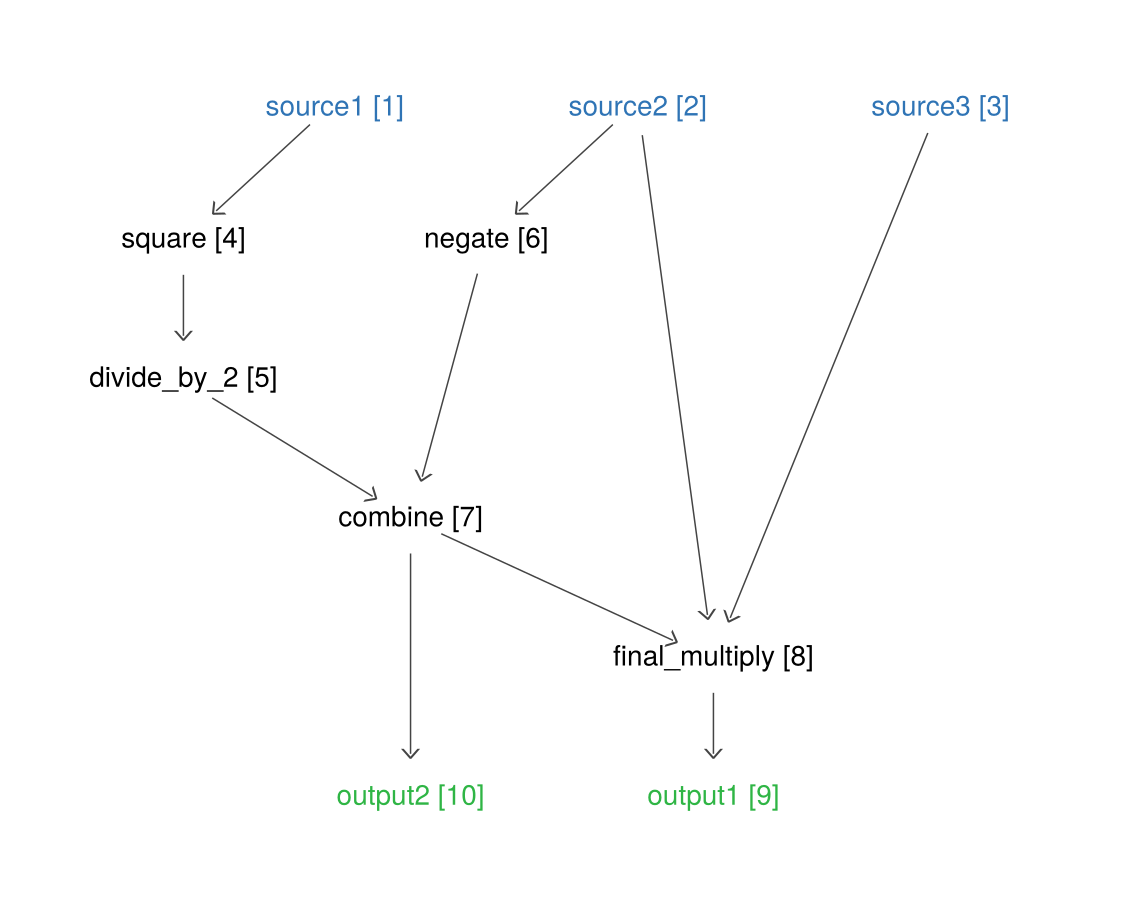

In [31]:
using Colors
using CairoMakie
using GraphMakie
using Graphs
using LayeredLayouts

function calc_max_depth(graph::StreamGraph)
    isempty(graph.nodes) && return 0
    isempty(graph.source_nodes) && return 1 # no source nodes, should not happen

    depths = fill(0, length(graph.nodes))
    
    function dfs(node)
        if depths[node] != 0
            return depths[node]
        end
        if isempty(graph.reverse_deps[node])
            depths[node] = 1
        else
            depths[node] = 1 + maximum(dfs(dep) for dep in graph.reverse_deps[node])
        end
        depths[node]
    end

    # Start DFS from each source node
    dfs.(graph.source_nodes)

    maximum(depths)
end

function visualize_graph(graph::StreamGraph)
    nodes = graph.nodes
    g = SimpleDiGraph(length(nodes))
    nlabels = String[]
    max_depth = calc_max_depth(graph)
    
    # Create a mapping from node IDs to graph indices
    force_layers = Vector{Pair{Int, Int}}()
    nlabels_align = []
    nlabels_color = []

    for (i, node) in enumerate(nodes)
        label = "$(node.label) [$(graph.topo_order[node.index])]"
        push!(nlabels, label)
        if is_source(node)
            push!(force_layers, i => 1) # source layers always at level 1
            push!(nlabels_align, (:center, :bottom))
            push!(nlabels_color, colorant"#2f74b5") # blue
        elseif is_sink(node)
            push!(force_layers, i => max_depth) # sink layers at the last level
            push!(nlabels_align, (:center, :top))
            push!(nlabels_color, colorant"#2fb545") # green
        else
            push!(nlabels_align, (:center, :top))
            push!(nlabels_color, colorant"#000")
        end
        
        for dep_id in graph.deps[node.index]
            add_edge!(g, nodes[dep_id].index, nodes[node.index].index)
        end
    end

    xs, ys, paths = solve_positions(Zarate(), g; force_layer=force_layers)
    xs, ys = ys, -xs # rotate coordinates by 90°
    ys .*= 0.4 # scale the y coordinates

    f, ax, p = graphplot(g;
        layout=Point.(zip(xs, ys)),
        arrow_size=15,
        arrow_shift=:end,
        arrow_marker='>',
        edge_width=0.75,
        edge_color=colorant"#444",
        nlabels=nlabels,
        nlabels_fontsize=14,
        nlabels_align=nlabels_align,
        nlabels_color=nlabels_color,
        node_size=48,
        node_color=:white,
        nlabels_distance=-10,
    )
    hidedecorations!(ax)
    hidespines!(ax)

    # add some padding
    x_range, y_range = extrema(xs), extrema(ys)
    x_range, y_range = x_range[2] - x_range[1], y_range[2] - y_range[1]
    xlims!(ax, minimum(xs) - 0.2x_range, maximum(xs) + 0.2x_range)
    ylims!(ax, minimum(ys) - 0.1y_range, maximum(ys) + 0.1y_range)

    # adjust width to match aspect ratio
    height = size(f.scene)[2]
    width = floor(Int, height*(x_range / y_range))
    resize!(f, width, height)
    
    f, ax, p
end

f, ax, p = visualize_graph(exe.graph)

# Save the plot to a file
# save("computation_graph.png", f)

display(f);

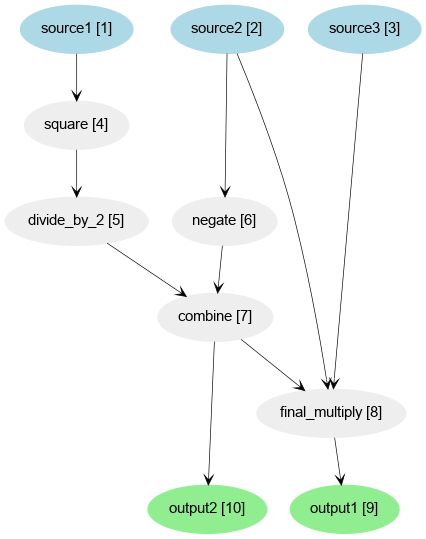

digraph G {
  node [fontsize=11, fontname="Helvetica,Arial,sans-serif"];
  { rank=source; 
    node1 [label="source1 [1]", style=filled, shape=ellipse, color=lightblue];
    node2 [label="source2 [2]", style=filled, shape=ellipse, color=lightblue];
    node3 [label="source3 [3]", style=filled, shape=ellipse, color=lightblue];
  }
  node4 [label="square [4]", style=filled, shape=ellipse, color="#eeeeee"];
  node5 [label="divide_by_2 [5]", style=filled, shape=ellipse, color="#eeeeee"];
  node6 [label="negate [6]", style=filled, shape=ellipse, color="#eeeeee"];
  node7 [label="combine [7]", style=filled, shape=ellipse, color="#eeeeee"];
  node8 [label="final_multiply [8]", style=filled, shape=ellipse, color="#eeeeee"];
  { rank=sink; 
    node9 [label="output1 [9]", style=filled, shape=ellipse, color=lightgreen];
    node10 [label="output2 [10]", style=filled, shape=ellipse, color=lightgreen];
  }
  node1 -> node4 [arrowhead=open, penwidth=0.5, arrowsize=0.75];
  node4 -> node5 [arrowhead

In [57]:
import ShowGraphviz

function generate_graphviz(graph::StreamGraph; fontsize=11)
    io = IOBuffer()
    
    println(io, "digraph G {")
    println(io, "  node [fontsize=$fontsize, fontname=\"Helvetica,Arial,sans-serif\"];")
    
    function make_label(node::StreamNode)
        return "$(node.label) [$(node.index)]"
    end

    # Source nodes (at the top)
    println(io, "  { rank=source; ")
    for node in graph.nodes
        if is_source(node)
            println(io, "    node$(node.index) [label=\"$(make_label(node))\", style=filled, shape=ellipse, color=lightblue];")
        end
    end
    println(io, "  }")

    # Computation nodes
    for node in graph.nodes
        if !is_source(node) && !is_sink(node)
            println(io, "  node$(node.index) [label=\"$(make_label(node))\", style=filled, shape=ellipse, color=\"#eeeeee\"];")
        end
    end

    # Sink nodes (at the bottom)
    println(io, "  { rank=sink; ")
    for node in graph.nodes
        if is_sink(node)
            println(io, "    node$(node.index) [label=\"$(make_label(node))\", style=filled, shape=ellipse, color=lightgreen];")
        end
    end
    println(io, "  }")
    
    # Add edges to the graph
    for (i, node) in enumerate(graph.nodes)
        for input_node in node.inputs
            println(io, "  node$(input_node.index) -> node$(node.index) [arrowhead=open, penwidth=0.5, arrowsize=0.75];")
        end
    end
    
    println(io, "}")
    
    String(take!(io))
end

gv_str = generate_graphviz(exe.graph)

display(ShowGraphviz.DOT(gv_str))
println(gv_str)

In [ ]:
g = StreamGraph()

# Create source nodes
source2 = source!(Float64, g; init=0.0, label="source2")

# Create compute nodes
negate1 = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate1")
multiply = op!(Float64, g, (exe, x) -> 5x; init=0.0, label="multiply")
combine = op!(Tuple{Float64,Float64}, g, (exe, x, y) -> (x, y); init=(0.0, 0.0), label="combine")
negate2 = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate2")
negate3 = op!(Float64, g, (exe, x) -> -x; init=0.0, label="negate3")
final_multiply = op!(Tuple{Float64,Float64}, g, (exe, tuple, src2, src3) -> tuple .* src2 .+ src3; init=(0.0, 0.0), label="final_multiply")

# Create sink nodes
output1 = sink!(g, (exe, x) -> println("output #1 at time $(time(exe)): $x"); label="output1")
output2 = sink!(g, (exe, x) -> println("output #2 at time $(time(exe)): $x"); label="output2")
output3 = sink!(g, (exe, x) -> println("output #3 at time $(time(exe)): $x"); label="output3")

# Create edges between nodes (define the computation graph)
source2 |> negate1
source2 |> multiply
(negate1, multiply) |> combine
(combine, source2) |> final_multiply
final_multiply |> output1
combine |> negate2
negate2 |> negate3
negate3 |> output2
negate2 |> output3

exe = compile_historic_executor(DateTime, g)

f, ax, p = visualize_graph(exe.graph)
display(f);